# Problem

$\blacktriangleright$ Here the problem that has to be faced is the simulation of the incompressible Navier-Stokes equation in a $\Omega$ domain that is a bifurcation that is a domain with two outlets, in the upper one the duct has to be physically truncated (a condition on the strain-rate tensor) while in lower one it has to be only numerically trucated (laplacian neumann boundary conditions or _do-nothing-conditions_). But at the very end choosing which formulation has to be used as governing equation is fundamental, the div-grad formulation of the NS equation or the laplacian one? let's see it

1. Definition of the problem in strong formulation, especially the div-grad formulation
\begin{equation}
    \begin{cases}
        -\text{div}(2\nu D(u)) + (u\cdot \nabla ) u + \nabla p=0 &\qquad in \thinspace \Omega\\
        \text{div}u=0 &\qquad in \thinspace \Omega\\
        u=(2-y)(2+y)/4 &\qquad on \thinspace \Gamma_{in}\\
        u=0 &\qquad on \thinspace \Gamma_{4}\\
        u\cdot \hat{t}=0,\thinspace (2\nu D(u) -pI)\hat{n}\cdot \hat{t}=0  &\qquad on \thinspace \Gamma_{2}\\
        (2\nu D(u) -pI)\hat{n}=0  &\qquad on \thinspace \Gamma_{3}\\
        u=u_{Stokes} &\qquad on \thinspace \Omega
    \end{cases}
\end{equation}
we have no-slip on the walls while on the outlet $2$ the only way to get the laplacian neumann conditions is to create a sort of modified free-slip(symmetricity) condition but not on the normal component as usual, but on the tangential one!
2. Functional Spaces, both for velocity and pressure and Taylor-Hood FEM elements $\mathbb{P}_2-\mathbb{P}_1$ (for velocity and pressure) in order to fullfill the _inf-sup conditions_
$$Q\in L^2(\Omega),\thinspace V_0=\{v\in [H^1_{\Gamma_{in}}(\Omega)]^2: v\cdot n=0\},\thinspace V=\{v\in [H^1(\Omega)]^2: v=v_{in},\thinspace v\cdot n=0\}$$

3. The weak formulation of the problem, using the Newton method for the treatment of the non-linear advection term
\begin{align}
 \int_{\Omega}2\nu D(u_k):D(v)d\Omega+\int_{\Omega}(u_k\cdot \nabla)u_{k+1}vd\Omega +\int_{\Omega}(u_{k+1}\cdot \nabla)u_{k}vd\Omega -\int_{\Omega}p_k\text{div}vd\Omega + \int_{\Omega}q\text{div}u_kd\Omega=\int_{\Omega}(u_k\cdot\nabla)u_{k+1}vd\Omega
\end{align}
while linearizing the problem using the Fixed point method, reads
\begin{align}
 \int_{\Omega}2\nu D(u_k):D(v)d\Omega+\int_{\Omega}(u_k\cdot \nabla)u_{k+1}vd\Omega -\int_{\Omega}p_k\text{div}vd\Omega + \int_{\Omega}q\text{div}u_kd\Omega=0
 \end{align}

4. I used as initial condtions for the NS solution, the solution of the associated Stokes problem associated to the NS one i.e. a Navier-Stokes system but without the non-linear term

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake


In [ ]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from firedrake.petsc import PETSc

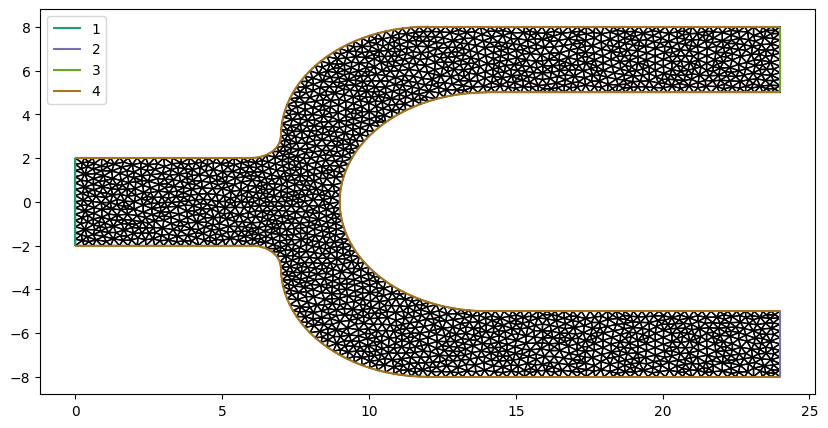

In [ ]:
# Import mesh: set the path correctly!
mesh = Mesh('/content/drive/MyDrive/meshes/bifurc.msh')
fig, ax = plt.subplots(figsize=(10, 5))
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [ ]:
V=VectorFunctionSpace(mesh,'P',2)
Q=FunctionSpace(mesh,'P',1)
W=MixedFunctionSpace([V,Q])


x=SpatialCoordinate(mesh)
u_in=as_vector(((2-x[1])*(2+x[1]),0))
u_noslip=Constant((0,0))
bc_in=DirichletBC(W.sub(0),u_in,1)
bc_noslip=DirichletBC(W.sub(0),u_noslip,4)
bc_freeslip=DirichletBC(W.sub(0).sub(1),Constant(0),2)
bcsU=(bc_in,bc_noslip,bc_freeslip)

nu=0.1
f=Constant((0,0))

In [ ]:
def steady_newton(u,v,p,q,nu,u_old):
  a=+dot(dot(grad(u),u_old),v)*dx\
    +dot(dot(grad(u_old),u),v)*dx\
    +2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
    -p*div(v)*dx\
    +q*div(u)*dx
  L=dot(dot(grad(u_old),u_old),v)*dx
  return a,L

def fixed_point(u,v,p,q,nu,u_old):
  a=+dot(dot(grad(u),u_old),v)*dx\
    +2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
    -p*div(v)*dx\
    +q*div(u)*dx
  L=dot(f,v)*dx
  return a,L

def stokes_initialization(u,v,q,p,nu):
  a=+2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
     -p*div(v)*dx\
      +q*div(u)*dx
  L=dot(f,v)*dx
  return a,L

In [ ]:
u,p=TrialFunctions(W)
v,q=TestFunctions(W)


In [ ]:
#nsp = MixedVectorSpaceBasis (W, [W. sub (0) ,VectorSpaceBasis ( constant = True )])

In [ ]:
wh_init=Function(W)
uh_init,ph_init=wh_init.subfunctions

wh=Function(W)
uh,ph=wh.subfunctions

uh_old=Function(V)
ph_old=Function(Q)

uh_old.assign(uh_init)
ph_old.assign(ph_init)



Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x791e64312810>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 144)), 345)

In [ ]:
a_stokes,L_stokes=stokes_initialization(u,v,q,p,nu)
problem_stokes=LinearVariationalProblem(a_stokes,L_stokes,wh_init,bcsU)
solver_stokes=LinearVariationalSolver(problem_stokes)
solver_stokes.solve()

In [ ]:
"""fig, ax = plt.subplots()
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')"""


"fig, ax = plt.subplots()\ncol = tripcolor(ph, axes=ax)\nplt.colorbar(col)\nplt.title('pressure')\nfig, ax = plt.subplots()\ncol = quiver(uh, axes=ax)\nplt.colorbar(col)\nplt.title('velocity')"

In [ ]:
a,L=steady_newton(u,v,p,q,nu,uh_old)
problem=LinearVariationalProblem(a,L,wh,bcsU)
solver=LinearVariationalSolver(problem)
solver.solve()

In [ ]:
# vtk output for Paraview
basename = '080224'
outfileU = File("/content/drive/MyDrive/4Test/velocity.pvd")
outfileP = File("/content/drive/MyDrive/4Test/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)

/usr/local/lib/python3.11/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


In [ ]:
maxit = 100
it = 0
tol = 1e-5
err = tol+1

while it <= maxit and err > tol:

    it += 1
    print("it",it)
    err=errornorm(uh,uh_old,'H1')/norm(uh_old,'H1')+errornorm(ph,ph_old,'L2')/norm(ph_old,'L2')
    print(err)
    a,L=fixed_point(u,v,p,q,nu,uh_old)
    problem=LinearVariationalProblem(a,L,wh,bcsU)
    solver=LinearVariationalSolver(problem)
    solver.solve()

    uh.rename("Velocity")
    ph.rename("Pressure")

    outfileU.write(uh, time=it)
    outfileP.write(ph, time=it)

    uh_old.assign(uh)
    ph_old.assign(ph)

it 1
inf


<ipython-input-68-a0dbd3321d05>:10: RuntimeWarning: divide by zero encountered in scalar divide
  err=errornorm(uh,uh_old,'H1')/norm(uh_old,'H1')+errornorm(ph,ph_old,'L2')/norm(ph_old,'L2')


it 2
8.099538317365795e-17


Text(0.5, 1.0, 'velocity')

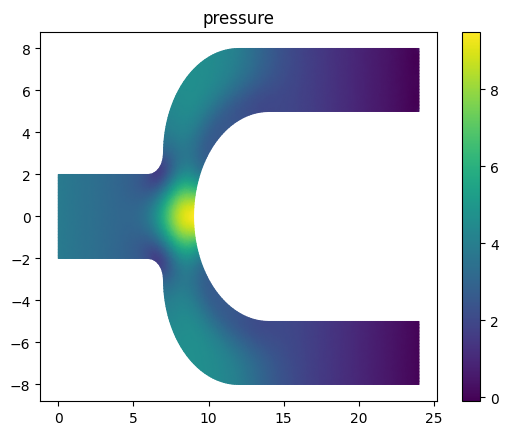

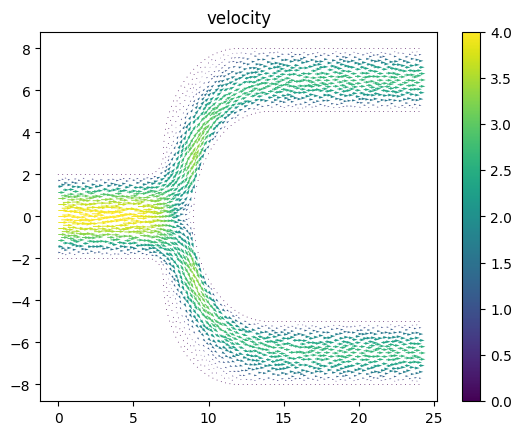

In [ ]:
fig, ax = plt.subplots()
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')

In [ ]:
normal=FacetNormal(mesh)
def flowrate(uh,label):
  return assemble(dot(uh,normal)*ds(label))

In [ ]:
flowr2=flowrate(uh,2)
flowr3=flowrate(uh,3)
print(flowr2,flowr3)

5.309442365887555 5.35722430077927


In [ ]:
u_y_L2 = sqrt(assemble((uh.sub(1)**2) * ds(2)))
u_y_L2

0.0

In [ ]:
uh_2=sqrt(assemble((uh[0]**2)*ds(2)))
print(uh_2)

3.357602540948346
